In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [3]:
votes = pd.DataFrame.from_csv('AnsVotes_TSeries.csv', index_col=None)
votes.head()

,QuestionId,AnsId,Age_vot,AnsWordCount,AcceptedAnsId,QScore,QVotes,Score,Votes,Upvotes,...,CumScore,ReScore,QReScore,Comments,AnsRank,ReScore_rank,Ans_count,Pbias,DRank,EPbias
0,1,56,0,201,56,0,0,2,2,2,...,0,0,0,0,1,1,1,1,0,1
1,2,10,0,145,10,0,0,3,3,3,...,0,0,0,0,1,1,1,1,0,1
2,2,10,0,145,10,0,0,3,3,3,...,0,0,0,0,1,1,1,1,0,1
3,3,9,0,25,109,0,0,4,4,4,...,0,0,0,0,1,1,1,1,0,1
4,7,16,0,45,2977,0,0,3,3,3,...,0,0,0,0,1,1,1,1,0,1


In [4]:
users = pd.DataFrame.from_csv('user_reputation_votes.csv', index_col=None)
users.head()

,AnsId,QContributed,AnsContributed,ScoreRcvQ,VotRcvQ,ScoreRcvAns,VotRcvAns,Age
0,1,1,0,1,1,0,0,0
1,55,0,1,0,0,1,1,0
2,55,0,1,0,0,2,2,0
3,55,0,1,0,0,3,3,0
4,55,0,1,0,0,4,4,0


In [5]:
#There can be posts/votes with deleted users, we avoid them here
m_votes = pd.merge(users, votes, how='inner', on=['AnsId'],suffixes=['_vot', '_user'])
get_head = lambda df: pd.DataFrame(dict(zip(df.iloc[0].index,[[e] for e in df.iloc[0].values])))
ff = lambda df: get_head(df.sort_values(by=["Age"],ascending=False))
votes_complete = m_votes[m_votes.Age_vot>=m_votes.Age].groupby(['AnsId','Age_vot']).apply(ff).reset_index(drop=True)
votes_complete.head()

,AcceptedAnsId,Age,Age_vot,AnsContributed,AnsId,AnsRank,AnsWordCount,Ans_count,Comments,CumScore,...,QuestionId,ReScore,ReScore_rank,Score,ScoreRcvAns,ScoreRcvQ,Upvotes,VotRcvAns,VotRcvQ,Votes
0,56,0,0,5,4,2,190,2,0,0,...,1,0.00,2,1,12,0,2,14,0,3
1,56,1436,1436,7,4,3,190,6,2,1,...,1,0.25,5,1,49,11,1,55,11,1
2,56,0,0,1,5,3,37,3,0,0,...,1,0.00,3,1,1,0,1,1,0,1
3,56,108,108,2,5,5,37,5,1,1,...,1,0.50,3,-1,-2,0,0,4,0,1
4,10,0,0,1,6,5,51,5,0,0,...,2,0.00,5,1,1,0,1,1,0,1


In [6]:
from functools import partial

votes_complete['Reputation'] = votes_complete['VotRcvQ'] + votes_complete['VotRcvAns']
qtls_age = votes_complete['Age_vot'].quantile([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1.0]).values
age_groups = dict(zip(zip(qtls_age,qtls_age[1:]),[e for e in range(len(zip(qtls_age,qtls_age[1:])))]))

qtls_rep = votes_complete['Reputation'].quantile([0,.25,.5,.75,1.0]).values
rep_groups = dict(zip(zip(qtls_rep,qtls_rep[1:]),[e for e in range(len(zip(qtls_rep,qtls_rep[1:])))]))

def get_group(intervals,pred):
    for l,u in intervals:
        if l<=pred and pred<=u:
            return intervals[(l,u)]
get_age_group = partial(get_group,age_groups)
get_rep_group = partial(get_group,rep_groups)

In [7]:
votes_complete['Age_group'] = votes_complete['Age_vot'].apply(get_age_group)
votes_complete['Rep_group'] = votes_complete['Reputation'].apply(get_rep_group)
votes_r = votes_complete

In [8]:
rev_age_groups = {age_groups[(d1,d2)]:"%d to %d days"%(d1,d2) for d1,d2 in age_groups}

# Start Last

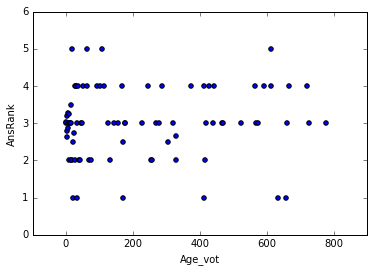

In [15]:

up_to_age = 8
level_top = 5
level_start = 3
first_occs = votes_complete.sort_values(by='Age_vot').groupby('AnsId').first().reset_index(drop=False)
first_occs = first_occs[(first_occs.AnsRank==level_start)&(first_occs.Ans_count==level_start)]['AnsId']
all_eq = votes_complete.sort_values(by='Age_vot').groupby('AnsId').apply(lambda df: (df.Ans_count==df.Ans_count.iloc[0]).all())
to_level = votes_complete.groupby('AnsId').apply(lambda df: df.Ans_count.max()>1 and df.Ans_count.max()<=level_top)

sel_occs = votes_complete[votes_complete['AnsId'].isin(all_eq[all_eq==False].index)]
sel_occs = sel_occs[sel_occs['AnsId'].isin(to_level[to_level==True].index)]
sel_occs = sel_occs[sel_occs['AnsId'].isin(first_occs)]['AnsId']


end_first_path_1 = votes_complete[votes_complete['AnsId'].isin(sel_occs)][['AnsId','AnsRank','DRank','Age_vot','Votes','Score','ReScore','Age_group','Ans_count']]
end_first_path_1[(end_first_path_1.Age_group<=up_to_age)].groupby(['Age_vot']).mean().reset_index(drop=False).plot(x='Age_vot',y='AnsRank',kind='scatter')

In [392]:
inc_seq = end_first_path_1.groupby(['AnsId']).apply(lambda df: pd.algos.is_monotonic_float64(df.AnsRank.values, False)[0] and not (df.Ans_count==df.Ans_count.iloc[0]).all())
inc_seq = inc_seq[inc_seq==True].index
dec_seq = end_first_path_1.groupby(['AnsId']).apply(lambda df: pd.algos.is_monotonic_float64(df.AnsRank.iloc[::-1].values, False)[0] and not (df.Ans_count==df.Ans_count.iloc[0]).all())
dec_seq = dec_seq[dec_seq==True].index

Mean: 0.58 , Var:0.09 


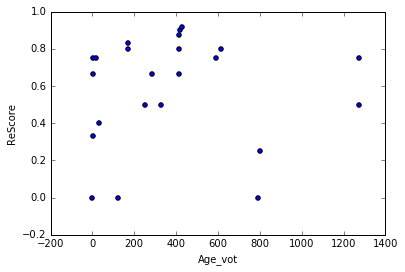

In [393]:
rscore_time_nm = end_first_path_1.sort_values(by='Age_vot')[(~end_first_path_1.AnsId.isin(dec_seq))&(~end_first_path_1.AnsId.isin(inc_seq))]
rscore_time_nm = rscore_time_nm.groupby(by='Age_vot').mean().reset_index(drop=False)

rscore_time_nm.plot(x='Age_vot',y='ReScore', kind='scatter')
print "Mean: %.2f , Var:%.2f "%(rscore_time_nm.ReScore.mean(),rscore_time_nm.ReScore.var())

Mean: 0.46 , Var:0.08 


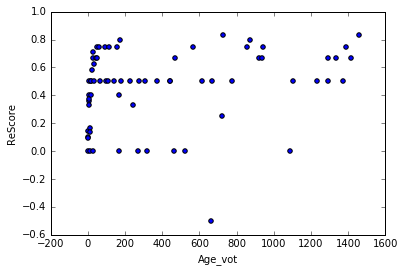

In [394]:
rscore_time_inc = end_first_path_1.sort_values(by='Age_vot')[end_first_path_1.AnsId.isin(inc_seq)]
rscore_time_inc = rscore_time_inc.groupby(by='Age_vot').mean().reset_index(drop=False)

rscore_time_inc.plot(x='Age_vot',y='ReScore', kind='scatter')
print "Mean: %.2f , Var:%.2f "%(rscore_time_inc.ReScore.mean(),rscore_time_inc.ReScore.var())

Mean: 0.41 , Var:0.15 


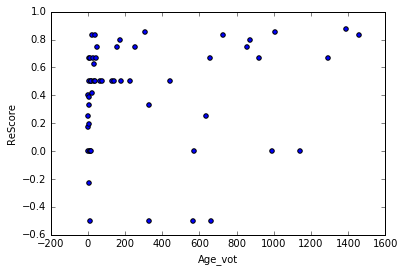

In [395]:
rscore_time_dec = end_first_path_1.sort_values(by='Age_vot')[end_first_path_1.AnsId.isin(dec_seq)]
rscore_time_dec = rscore_time_dec.groupby(by='Age_vot').mean().reset_index(drop=False)
rscore_time_dec.plot(x='Age_vot',y='ReScore', kind='scatter')
print "Mean: %.2f , Var:%.2f "%(rscore_time_dec.ReScore.mean(),rscore_time_dec.ReScore.var())

# Classify slope

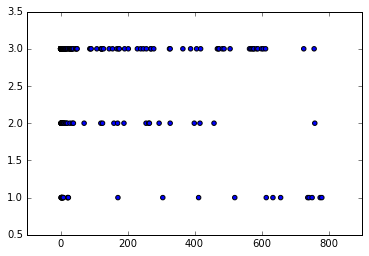

In [261]:
fml = 'AnsRank ~ Age_vot'

r_method = sm.families.NegativeBinomial(link=sm.families.links.log)
datas = end_first_path_1[(end_first_path_1.AnsRank<=level)]

fit_nbin = lambda df : smf.glm(fml, data=df, family=r_method, offset=np.log(df['Age_vot'])).fit(method='bfgs')
classify_slope = lambda df: 'k' if (df.shape[0]<3 or fit_nbin(df).pvalues[1]>0.05) else 'r' if fit_nbin(df).params[1]>=0 else 'b'
fill_slope = lambda df: pd.Series([classify_slope(df)],index=df.index,name='color')

class_data = datas.sort_values(by='Age_vot').groupby(['AnsId']).apply(lambda df: pd.concat([df.Age_vot,df.AnsRank,fill_slope(df),df.Age_group],axis=1))
class_data = class_data[(class_data.color!='k')&(class_data.Age_group<=up_to)]

fig, ax = plt.subplots()
colors = {'k':'black', 'b':'blue', 'r':'red'}
ax.scatter(class_data['Age_vot'], class_data['AnsRank'], c=class_data['color'].apply(lambda x: colors[x]))
plt.show()

## Start First

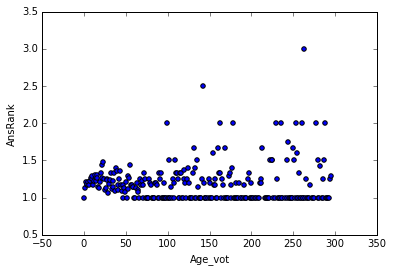

In [262]:
level = 3
up_to = 7

first_occs = votes_complete.sort_values(by='Age_vot').groupby('AnsId').first().reset_index(drop=False)
first_occs = first_occs[(first_occs.AnsRank==1)]['AnsId']
first_occs = votes_complete[votes_complete['AnsId'].isin(first_occs)]['AnsId']

end_first_path_2 = votes_complete[votes_complete['AnsId'].isin(first_occs)][['AnsId','AnsRank','DRank','Age_vot','Votes','Score','ReScore','Age_group']]
end_first_path_2[(end_first_path_2.AnsRank<=level)&(end_first_path_2.Age_group<=up_to)].groupby(['Age_vot']).mean().reset_index(drop=False).plot(x='Age_vot',y='AnsRank',kind='scatter')

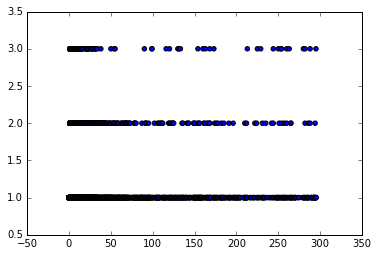

In [264]:
fml = 'AnsRank ~ Age_vot'

r_method = sm.families.NegativeBinomial(link=sm.families.links.log)
datas = end_first_path_2[(end_first_path_2.AnsRank<=level)]

fit_nbin = lambda df : smf.glm(fml, data=df, family=r_method, offset=np.log(df['Age_vot'])).fit(method='bfgs')
classify_slope = lambda df: 'k' if (df.shape[0]<3 or fit_nbin(df).pvalues[1]>0.05) else 'r' if fit_nbin(df).params[1]>=0 else 'b'
fill_slope = lambda df: pd.Series([classify_slope(df)],index=df.index,name='color')

class_data = datas.sort_values(by='Age_vot').groupby(['AnsId']).apply(lambda df: pd.concat([df.Age_vot,df.AnsRank,fill_slope(df),df.Age_group,df.AnsId],axis=1))
class_data = class_data[(class_data.color!='k')&(class_data.Age_group<=up_to)&(class_data['AnsId'].isin(first_occs))]

fig, ax = plt.subplots()
colors = {'k':'black', 'b':'blue', 'r':'red'}
ax.scatter(class_data['Age_vot'], class_data['AnsRank'], c=class_data['color'].apply(lambda x: colors[x]))
plt.show()

## Start last end first

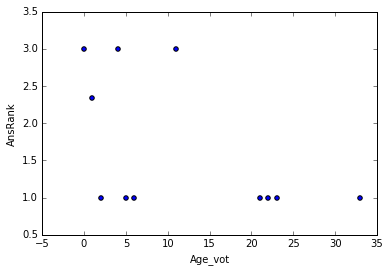

In [274]:
level = 3
up_to = 7

first_occs = votes_complete.sort_values(by='Age_vot').groupby('AnsId').first().reset_index(drop=False)
first_occs = first_occs[(first_occs.AnsRank==level)]['AnsId']
last_occs = votes_complete.sort_values(by='Age_vot').groupby('AnsId').last().reset_index(drop=False)
sel_occs = last_occs[(last_occs.AnsRank==1)&(last_occs.Ans_count==level)&(last_occs['AnsId'].isin(first_occs))]['AnsId']

end_first_path_3 = votes_complete[votes_complete['AnsId'].isin(sel_occs)][['AnsId','AnsRank','DRank','Age_vot','Votes','Score','ReScore','Age_group']]
end_first_path_3[(end_first_path_3.AnsRank<=level)&(end_first_path_3.Age_group<=up_to)].groupby(['Age_vot']).mean().reset_index(drop=False).plot(x='Age_vot',y='AnsRank',kind='scatter')

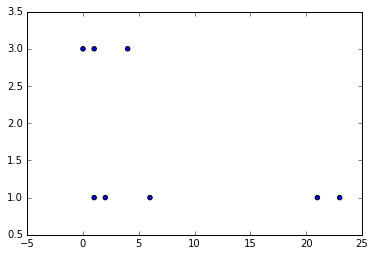

In [270]:
fml = 'AnsRank ~ Age_vot'

r_method = sm.families.NegativeBinomial(link=sm.families.links.log)
datas = end_first_path_3[(end_first_path_3.AnsRank<=level)]

fit_nbin = lambda df : smf.glm(fml, data=df, family=r_method, offset=np.log(df['Age_vot'])).fit(method='bfgs')
classify_slope = lambda df: 'k' if (df.shape[0]<3 or fit_nbin(df).pvalues[1]>0.05) else 'r' if fit_nbin(df).params[1]>=0 else 'b'
fill_slope = lambda df: pd.Series([classify_slope(df)],index=df.index,name='color')

class_data = datas.sort_values(by='Age_vot').groupby(['AnsId']).apply(lambda df: pd.concat([df.Age_vot,df.AnsRank,fill_slope(df),df.Age_group,df.AnsId],axis=1))
class_data = class_data[(class_data.color!='k')&(class_data.Age_group<=up_to)&(class_data['AnsId'].isin(first_occs))]

fig, ax = plt.subplots()
colors = {'k':'black', 'b':'blue', 'r':'red'}
ax.scatter(class_data['Age_vot'], class_data['AnsRank'], c=class_data['color'].apply(lambda x: colors[x]))
plt.show()

## Start first end last

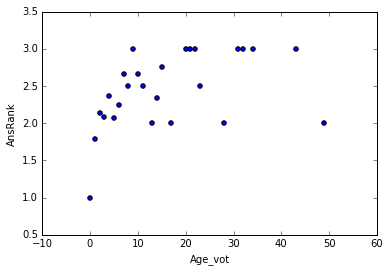

In [271]:
level = 3
up_to = 6

first_occs = votes_complete.sort_values(by='Age_vot').groupby('AnsId').first().reset_index(drop=False)
first_occs = first_occs[(first_occs.AnsRank==1)]['AnsId']
last_occs = votes_complete.sort_values(by='Age_vot').groupby('AnsId').last().reset_index(drop=False)
sel_occs = last_occs[(last_occs.AnsRank==level)&(last_occs.Ans_count==level)&(last_occs['AnsId'].isin(first_occs))]['AnsId']

end_first_path_4 = votes_complete[votes_complete['AnsId'].isin(sel_occs)][['AnsId','AnsRank','DRank','Age_vot','Votes','Score','ReScore','Age_group']]
end_first_path_4[(end_first_path_4.AnsRank<=level)&(end_first_path_4.Age_group<=up_to)].groupby(['Age_vot']).mean().reset_index(drop=False).plot(x='Age_vot',y='AnsRank',kind='scatter')

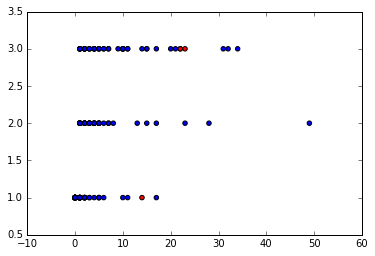

In [272]:
fml = 'AnsRank ~ Age_vot'

r_method = sm.families.NegativeBinomial(link=sm.families.links.log)
datas = end_first_path_4[(end_first_path_4.AnsRank<=level)]

fit_nbin = lambda df : smf.glm(fml, data=df, family=r_method, offset=np.log(df['Age_vot'])).fit(method='bfgs')
classify_slope = lambda df: 'k' if (df.shape[0]<3 or fit_nbin(df).pvalues[1]>0.05) else 'r' if fit_nbin(df).params[1]>=0 else 'b'
fill_slope = lambda df: pd.Series([classify_slope(df)],index=df.index,name='color')

class_data = datas.sort_values(by='Age_vot').groupby(['AnsId']).apply(lambda df: pd.concat([df.Age_vot,df.AnsRank,fill_slope(df),df.Age_group,df.AnsId],axis=1))
class_data = class_data[(class_data.color!='k')&(class_data.Age_group<=up_to)&(class_data['AnsId'].isin(first_occs))]

fig, ax = plt.subplots()
colors = {'k':'black', 'b':'blue', 'r':'red'}
ax.scatter(class_data['Age_vot'], class_data['AnsRank'], c=class_data['color'].apply(lambda x: colors[x]))
plt.show()